In [1]:
from pyspark.sql import SparkSession
from pyspark.mllib.stat import Statistics

spark_session = SparkSession.builder\
        .master("spark://192.168.2.225:7077") \
        .appName("test")\
        .config("spark.dynamicAllocation.enabled", True)\
        .config("spark.dynamicAllocation.shuffleTracking.enabled",True)\
        .config("spark.shuffle.service.enabled", False)\
        .config("spark.dynamicAllocation.executorIdleTimeout","30s")\
        .config("spark.executor.cores", 2)\
        .config("spark.driver.port",9999)\
        .config("spark.blockManager.port",10005)\
        .getOrCreate()

# RDD API
spark_context = spark_session.sparkContext

# spark_context.setLogLevel("INFO")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/03/13 11:38:26 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
json_rdd = spark_context.textFile("hdfs://192.168.2.225:9000/user/ubuntu/corpus-webis-tldr-17.json")\
                        .map(lambda line: eval(line))  # Assuming each line is a dictionary representation

# # Extract the 'subreddit' field from each dictionary
# subreddits_rdd = json_rdd.map(lambda record: record.get('subreddit', None))

# # Filter out None values and count the occurrences of each subreddit
# subreddit_counts_rdd = subreddits_rdd.filter(lambda x: x is not None) \
#                                     .map(lambda subreddit: (subreddit, 1)) \
#                                     .reduceByKey(lambda a, b: a + b)

# # Sort the subreddits by count in descending order
# sorted_subreddits_rdd = subreddit_counts_rdd.sortBy(lambda x: x[1], ascending=False)

# # Take the top 10 subreddits
# top_10_subreddits = sorted_subreddits_rdd.take(10)

# # Display the top 10 subreddits
# for subreddit, count in top_10_subreddits:
#     print(f"Subreddit: {subreddit}, Count: {count}")

# # Stop the SparkSession
# spark_session.stop()

# Subreddit: AskReddit, Count: 589947
# Subreddit: relationships, Count: 352049
# Subreddit: leagueoflegends, Count: 109307
# Subreddit: tifu, Count: 52219
# Subreddit: relationship_advice, Count: 50416
# Subreddit: trees, Count: 47286
# Subreddit: gaming, Count: 43851
# Subreddit: atheism, Count: 43268
# Subreddit: AdviceAnimals, Count: 40783
# Subreddit: funny, Count: 40171

In [ ]:
# Map each record to a tuple containing the length of the summary and the length of the text
lengths_rdd = json_rdd.map(lambda record: (len(record.get('summary', '')), len(record.get('content', ''))))

# Calculate the correlation between the two columns
correlation = Statistics.corr(lengths_rdd)

print("Correlation between summary length and text length:", correlation)

# Stop the SparkSession
spark_session.stop()

Correlation between summary length and text length: [[1.         0.32852918]
 [0.32852918 1.        ]]

24/03/12 23:49:33 WARN TransportChannelHandler: Exception in connection from /183.136.225.42:21348
java.lang.IllegalArgumentException: Too large frame: 5135603447292250188
	at org.sparkproject.guava.base.Preconditions.checkArgument(Preconditions.java:119)
	at org.apache.spark.network.util.TransportFrameDecoder.decodeNext(TransportFrameDecoder.java:148)
	at org.apache.spark.network.util.TransportFrameDecoder.channelRead(TransportFrameDecoder.java:98)
	at io.netty.channel.AbstractChannelHandlerContext.invokeChannelRead(AbstractChannelHandlerContext.java:444)
	at io.netty.channel.AbstractChannelHandlerContext.invokeChannelRead(AbstractChannelHandlerContext.java:420)
	at io.netty.channel.AbstractChannelHandlerContext.fireChannelRead(AbstractChannelHandlerContext.java:412)
	at io.netty.channel.DefaultChannelPipeline$HeadContext.channelRead(DefaultChannelPipeline.java:1410)
	at io.netty.channel.AbstractChannelHandlerContext.invokeChannelRead(AbstractChannelHandlerContext.java:440)
	at io.net

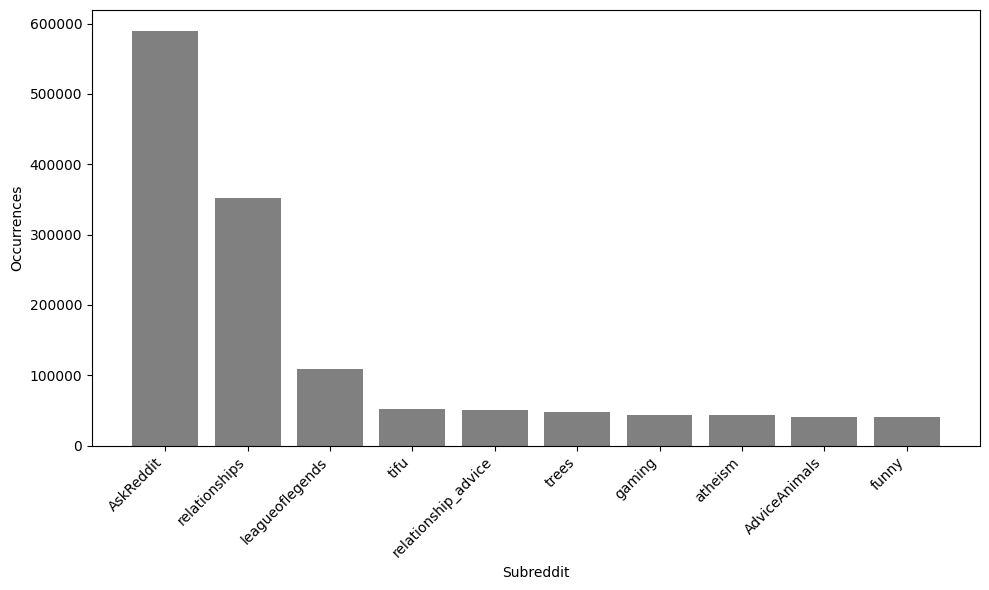

In [10]:
import matplotlib.pyplot as plt

# Subreddit names and their corresponding occurrences
subreddits = ['AskReddit', 'relationships', 'leagueoflegends', 'tifu', 'relationship_advice',
              'trees', 'gaming', 'atheism', 'AdviceAnimals', 'funny']
occurrences = [589947, 352049, 109307, 52219, 50416, 47286, 43851, 43268, 40783, 40171]

# Plotting the histogram
plt.figure(figsize=(10, 6))
plt.bar(subreddits, occurrences, color='gray')
plt.xlabel('Subreddit')
plt.ylabel('Occurrences')
# plt.title('Occurrences of Top 10 Subreddits')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Save the plot as a figure
plt.savefig('top_10_subreddits_histogram.png')

# Show the plot
plt.show()
